## Interpretation

* Black box models: we don't really know why a particular output decision (in the case of classification for example) is made. We don't know which feature was used.

* White box model: transparancy, we known which features were used and thus know how a decision was made.

* This brings us to the field of explainable AI


* Story time:

In the early days of the perceptron the army decided to train an artificial neural network to recognize tanks partly hidden behind trees in the woods. They took a number of pictures of a woods without tanks, and then pictures of the same woods with tanks clearly sticking out from behind trees. 

They then trained a net to discriminate the two classes of pictures. The results were impressive, and the army was even more impressed when it turned out that the net could generalize its knowledge to pictures from each set that had not been used in training the net. 

Just to make sure that the net had indeed learned to recognize partially hidden tanks, however, the researchers took some more pictures in the same woods and showed them to the trained net. They were shocked and depressed to find that with the new pictures the net totally failed to discriminate between pictures of trees with partially concealed tanks behind them and just plain trees. 

The mystery was finally solved when someone noticed that the training pictures of the woods without tanks were taken on a cloudy day, whereas those with tanks were taken on a sunny day. The net had learned to recognize and generalize the difference between a woods with and without shadows!

* Point being, we need to be able to interrogate our models, and investigate why certain decisions are made. In the case of CNNS this is important. Is a picture of a polar bear classified as a polar bear because of it's feature or because of the snow? It's easy to imagine such situations. **Try to imagine at least one and share with the rest of the class.**

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

%matplotlib inline

In [ ]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1Lu74Ti-CmFzHUYKKy0Bl0g326A9czRV8"})
downloaded.GetContentFile('flowers.zip')

zip_ref = zipfile.ZipFile("flowers.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

## Load the data
Use the flow from directory function to load the data -- we have seen this function before in an earlier practical.

In [ ]:
image_dir = "/tmp/flowers"
image_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rescale=1./255, validation_split=0.15)  

train_gen = image_datagen.flow_from_directory(image_dir, target_size=(299, 299), batch_size=32, class_mode="categorical", subset="training")
valid_gen = image_datagen.flow_from_directory(image_dir, target_size=(299, 299), batch_size=32, class_mode="categorical", subset="validation")

Found 3673 images belonging to 5 classes.
Found 644 images belonging to 5 classes.


## Create the model

We will use pre-trained weights.

In [ ]:
inp = Input((299, 299, 3))
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inp, input_shape=(299, 299, 3), pooling='avg')
x = resnet.output # get the last layer (i.e. the last feature extractor layer)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
out = Dense(5, activation='softmax')(x) # 5 class problem

complete_model = Model(inp, out)

complete_model.compile(optimizer='adam', loss='categorical_crossentropy')

94765736/94765736 [==============================] - 1s 0us/step


## Train the model

In [ ]:
history = complete_model.fit(train_gen, 
                             steps_per_epoch=115, 
                             epochs=10, 
                             validation_data=valid_gen, 
                             validation_steps=20, verbose=1)

Epoch 1/10
115/115 [==============================] - 132s 996ms/step - loss: 1.0150 - val_loss: 43.1008
Epoch 2/10
115/115 [==============================] - 110s 950ms/step - loss: 0.7077 - val_loss: 1.5989
Epoch 3/10
115/115 [==============================] - 110s 954ms/step - loss: 0.5966 - val_loss: 1.6605
Epoch 4/10
115/115 [==============================] - 110s 953ms/step - loss: 0.5126 - val_loss: 3.5063
Epoch 5/10
  7/115 [>.............................] - ETA: 1:35 - loss: 0.4324

KeyboardInterrupt: ignored

## Saliency Maps

This helps us figure out which pixels in the image are impacting the classification outputs. As a result, we can see which parts of the image are being used to determine the classification, and investigate if these make sense. We can also explore which models makes use of more appropriate features of the obejcts of interest.

Saliency maps tells us what parts of the image the model is focusing on when making its predictions.

With saliency maps, we are just shown the relevant pixels in the image and we do not get any information about what the features look like.

You can generate saliency maps by getting the gradient of the loss with respect to the image pixels.

## Refresher on auto differentiation and Tensorflow

* To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.

* TensorFlow provides the ```tf.GradientTape``` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually ```tf.Variables```. 

* TensorFlow "records" relevant operations executed inside the context of a ```tf.GradientTape``` onto a ```"tape"```. TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [ ]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

Once you've recorded some operations, use ```GradientTape.gradient(target, sources)``` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

In [ ]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

Slightly more complex example

In [ ]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  ss = tf.reduce_mean(y**2)

In [ ]:
[dl_dw, dl_db] = tape.gradient(ss, [w, b])
[dl_dw, dl_db]

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[  0.87594676, -10.682042  ],
        [  1.7518935 , -21.364084  ],
        [  2.6278403 , -32.046127  ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.87594676, -10.682042  ], dtype=float32)>]

Slightly more complex example. Here we have some model for which we are applying a foward pass in the gradient tape

In [ ]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  ss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(ss, layer.trainable_variables)

In [ ]:
grad

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[0.       , 0.7004409],
        [0.       , 1.4008818],
        [0.       , 2.1013227]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.       , 0.7004409], dtype=float32)>]

## Now to the main example

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Create a model using pre-trained weights

In [ ]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

### Download an image for which we will determine the saliency map

In [ ]:
#!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

# If you want to try the cat, uncomment this line
!wget -O image.jpg https://cdn.pixabay.com/photo/2015/03/27/13/16/maine-coon-694730_960_720.jpg

--2022-10-27 07:21:02--  https://cdn.pixabay.com/photo/2015/03/27/13/16/maine-coon-694730_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.11.234, 104.18.10.234, 2606:4700::6812:bea, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.11.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53016 (52K) [binary/octet-stream]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  51.77K  --.-KB/s    in 0.001s  

2022-10-27 07:21:02 (92.2 MB/s) - ‘image.jpg’ saved [53016/53016]



### Read the image and apply some preprocessing

In [ ]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

# Check the shape
image.shape

(1, 300, 300, 3)

### Plot

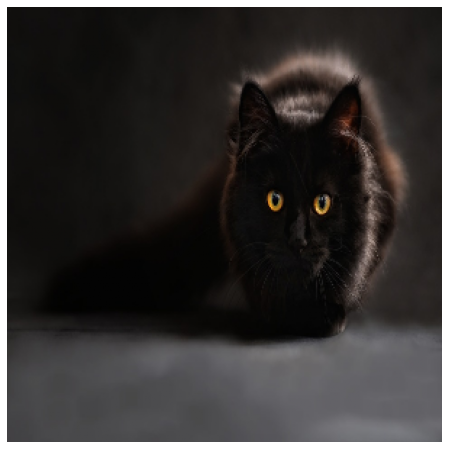

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#[251] * image.shape[0]

In [ ]:
# Siberian Husky's class ID in ImageNet
#class_index = 249  

# If you downloaded the cat, use this line instead
class_index = 284   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index], num_classes)

In [ ]:
expected_output

<tf.Tensor: shape=(1, 1001), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    # this is needed as tensorflow doesn't keep track of all data types
    tape.watch(inputs)

    # generate the predictions
    # Essentially, here we are performing a forward pass
    # so this is how the gradient tape becomes aware of the 
    # computational graph of our model and then we can 
    # compute the gradients with respect to the inputs
    # by backpropagating through the entire network
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

In [ ]:
# Network predictions for this image
predictions

<tf.Tensor: shape=(1, 1001), dtype=float32, numpy=
array([[4.4245015e-05, 5.5633875e-05, 3.7124853e-05, ..., 1.5307738e-05,
        1.0318185e-04, 3.3481585e-04]], dtype=float32)>

In [ ]:
np.argmax(predictions,axis=-1)

array([284])

In [ ]:
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.15864715], dtype=float32)>

In [ ]:
# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [ ]:
# We have the gradient for each pixel value
gradients.shape

TensorShape([1, 300, 300, 3])

## Visualize the results

Now that you have the gradients, you will do some postprocessing to generate the saliency maps and overlay it on the image.

In [ ]:
# reduce the RGB image to grayscale
# it currently have a depth of 3 so we can sum across
# the channels
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)
normalized_tensor.shape

TensorShape([300, 300])

In [ ]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor))
print(np.min(grayscale_tensor))
print()

1.0324905
0.0



In [ ]:
# max and min value in the grayscale tensor
print(np.max(normalized_tensor))
print(np.min(normalized_tensor))
print()

254
0



## Plot the saliency map

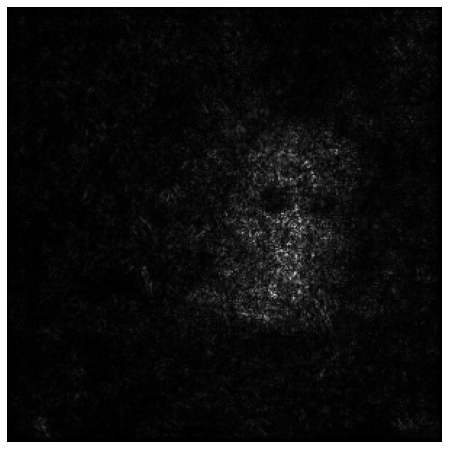

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

Let's superimpose the normalized tensor to the input image to get more context. You can see that the strong pixels are over the husky and that is a good indication that the model is looking at the correct part of the image.

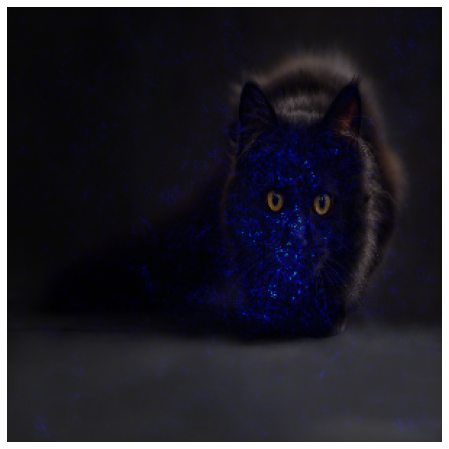

In [ ]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

# Tasks

* Explore Imagenet classes: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

* Download some other images from Pixabay, right click on the image, and select to copy the image link. Then replace it above where we download the image. You'll need to change the index of the correct class from the github list provided. Example of pixabay image: https://pixabay.com/photos/siamese-cat-puss-breed-cat-window-965285/